### link_to_view_the_model_performance: https://www.linkedin.com/posts/hui-liu-3b705a245_deeplearning-computervision-agriculture-activity-7020541019578384384-oos3?utm_source=share&utm_medium=member_desktop

### load the required packages

In [60]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report

from IPython.display import SVG, Image
from livelossplot.tf_keras import PlotLossesCallback
from livelossplot import PlotLossesKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.10.0


### count the images

In [12]:
train_path = os.getcwd() + '/Train'
test_path = os.getcwd() + '/Test' 
validation_path = os.getcwd() + '/Validation'

In [13]:
def count_images(file_path):
    for types in os.listdir(file_path):
        print('There are '+ str(len(os.listdir(file_path+ '/' + types))) + " " + types + ' images ' + "in the " + file_path.split('/')[-1] + " data\n")

In [19]:
count_images(train_path)

There are 430 Powdery images in the Train data

There are 458 Healthy images in the Train data

There are 434 Rust images in the Train data



In [20]:
img_number = []
for types in os.listdir(train_path):
    img_number.append(int(len(os.listdir(train_path+ '/' + types))))

img_df=pd.DataFrame({'img_number':img_number, 'img_type':['Powdery','Healthy', 'Rust' ]})

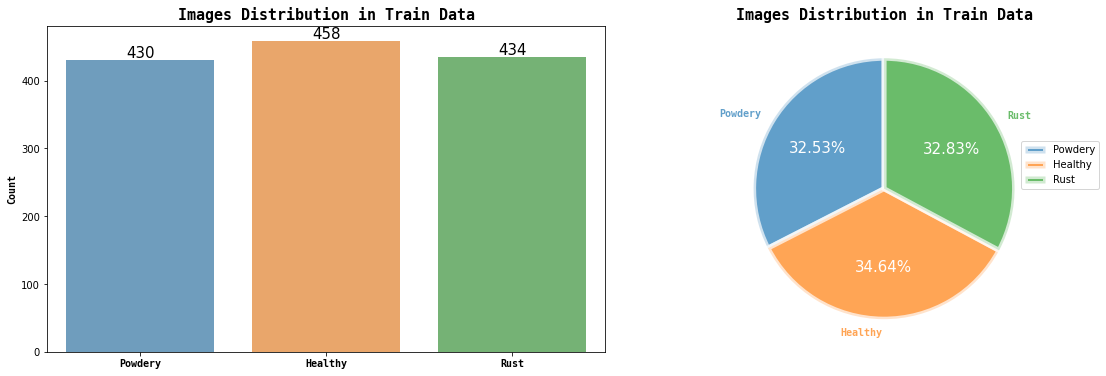

In [21]:
fig,axes = plt.subplots(1,2, figsize = (20,6),gridspec_kw=dict( wspace=0))
sns.barplot(data=img_df, x='img_type', y='img_number', alpha=0.7, ax=axes[0])
for i in axes[0].containers:
    axes[0].bar_label(i,size=15)
axes[0].set_ylabel('Count', font='monospace', weight='semibold')
axes[0].set_xlabel('')
axes[0].set_title('Images Distribution in Train Data', font='monospace', weight='semibold', size=15)
for i in axes[0].get_xticklabels():
    i.set_font('monospace')
    i.set_weight('semibold')
    
patches, texts, pcts = axes[1].pie(img_df['img_number'], labels=img_df['img_type'],wedgeprops={'linewidth': 5, 'edgecolor': 'white'},textprops={'size': 'x-large'}, startangle=90, autopct='%1.2f%%');
for i, patch in enumerate(patches):
    patch.set_alpha(0.7)
    texts[i].set_color(patch.get_facecolor())
axes[1].legend(loc=[0.92,0.5])
plt.setp(pcts, color='white', size=15)
plt.setp(texts, fontweight='semibold', font='monospace')
axes[1].set_title('Images Distribution in Train Data', font='monospace', weight='semibold', size=15);

In [22]:
count_images(test_path)

There are 50 Powdery images in the Test data

There are 50 Healthy images in the Test data

There are 50 Rust images in the Test data



In [23]:
count_images(validation_path)

There are 20 Powdery images in the Validation data

There are 20 Healthy images in the Validation data

There are 20 Rust images in the Validation data



### visualize the images

In [24]:
imgs_paths = []
for i in os.listdir(train_path):
    imgs = os.listdir(train_path + '/' + i)
    selected_imgs = np.random.choice(imgs, 3)
    for j in selected_imgs:
        imgs_paths.append(os.path.join(train_path, i, j))

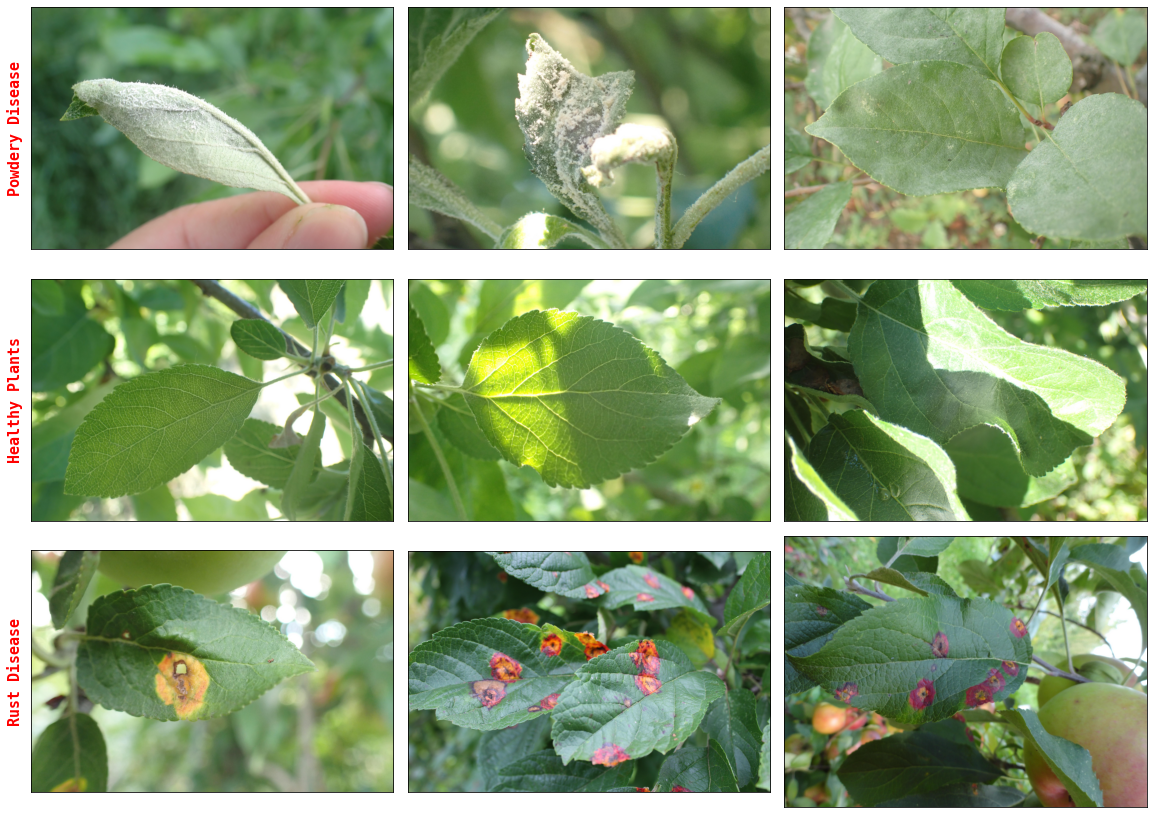

In [26]:
fig, axes = plt.subplots(3,3, figsize = (20,15), subplot_kw=dict(xticks=[], yticks=[]), gridspec_kw=dict(hspace=0, wspace=0.04))
for i, ax  in enumerate(axes.flat):
    ax.imshow(plt.imread(imgs_paths[i]))
axes[0,0].set_ylabel('Powdery Disease',font='monospace', weight='semibold', size=15, color='r')
axes[1,0].set_ylabel('Healthy Plants',font='monospace', weight='semibold', size=15,color='r')
axes[2,0].set_ylabel('Rust Disease',font='monospace', weight='semibold', size=15,color='r');

### create training and validation batches

In [167]:
img_size = (224, 224)
batch_size = 32

datagen_train = ImageDataGenerator(horizontal_flip = True)
train_generator = datagen_train.flow_from_directory(train_path, 
                                                    target_size=img_size, 
                                                    color_mode='rgb', 
                                                    batch_size=batch_size, 
                                                    class_mode='categorical', 
                                                    shuffle=True)


datagen_validation = ImageDataGenerator(horizontal_flip = True)
validation_generator = datagen_validation.flow_from_directory(test_path, 
                                                    target_size=img_size, 
                                                    color_mode='rgb', 
                                                    batch_size=batch_size, 
                                                    class_mode='categorical', 
                                                    shuffle=True)

datagen_test = ImageDataGenerator(horizontal_flip = True)
test_generator = datagen_test.flow_from_directory(validation_path, 
                                                    target_size=img_size, 
                                                    color_mode='rgb', 
                                                    batch_size=batch_size, 
                                                    class_mode='categorical', shuffle=False)
                                                    

Found 1322 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


### build the convolutional neural network model

In [81]:
model = Sequential()

model.add(Conv2D(32, (3,3),  padding='same', input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (5,5),  padding='same', input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(3, activation='softmax'))
opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_21 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 activation_21 (Activation)  (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 112, 112, 32)      0         
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 32)     

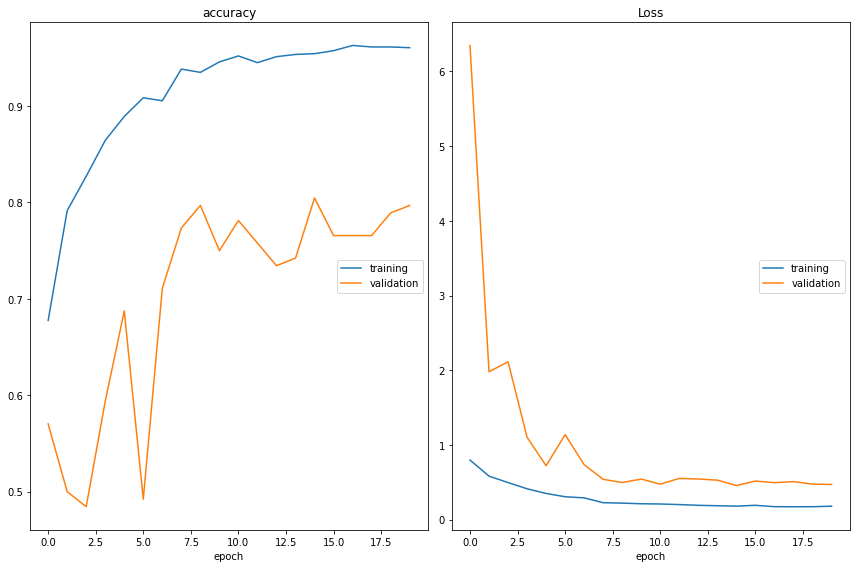

accuracy
	training         	 (min:    0.678, max:    0.963, cur:    0.960)
	validation       	 (min:    0.484, max:    0.805, cur:    0.797)
Loss
	training         	 (min:    0.172, max:    0.797, cur:    0.179)
	validation       	 (min:    0.456, max:    6.348, cur:    0.471)

Epoch 20: saving model to model_weights.h5
41/41 [==============================] - 162s 4s/step - loss: 0.1794 - accuracy: 0.9605 - val_loss: 0.4709 - val_accuracy: 0.7969 - lr: 1.0000e-05


In [82]:
epochs= 20
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_step = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='auto', verbose=1)
checkpoint = ModelCheckpoint('model_weights.h5', monitor='val_accuracy', verbose=1, save_weights_only=True, mode='max')

callbacks = [PlotLossesKeras(), checkpoint, reduce_lr]

history = model.fit(x = train_generator, steps_per_epoch = steps_per_epoch,
                   epochs=epochs,
                   validation_data=validation_generator,
                   validation_steps=validation_step,
                   callbacks=callbacks)

### make prediction

In [180]:
test_generator.class_indices

{'Healthy': 0, 'Powdery': 1, 'Rust': 2}

In [169]:
model.evaluate(test_generator)

2/2 [==============================] - 6s 3s/step - loss: 0.4547 - accuracy: 0.8333


[0.4547180235385895, 0.8333333134651184]

In [170]:
y_pred = model.predict(test_generator, test_generator.n//test_generator.batch_size)

2/2 [==============================] - 6s 3s/step


In [171]:
Y = np.argmax(y_pred, axis=1)

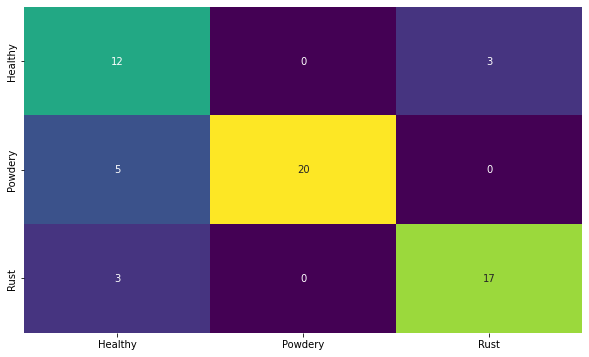

In [186]:
sns.heatmap(confusion_matrix(Y, test_generator.labels), annot=True, cbar=False, cmap='viridis', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices)
fig = plt.gcf()
fig.set_size_inches(10,6)

In [174]:
(print(classification_report(Y, test_generator.classes))

              precision    recall  f1-score   support

           0       0.60      0.80      0.69        15
           1       1.00      0.80      0.89        25
           2       0.85      0.85      0.85        20

    accuracy                           0.82        60
   macro avg       0.82      0.82      0.81        60
weighted avg       0.85      0.82      0.83        60



### Represet model as JSON string

In [187]:
model_json = model.to_json()
with open('model_json', 'w') as json_file:
    json_file.write(model_json)